In [1]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, QubitConverter
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer,FreezeCoreTransformer
import numpy as np
from qiskit.algorithms.optimizers import SLSQP
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator
from qiskit.algorithms.minimum_eigensolvers import AdaptVQE
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
import logging
logging.basicConfig(
    filename='1203.log',
    level=logging.INFO)
logger = logging.getLogger()

In [2]:
def LiH_adaptvqe(k,dist):
    
    # Define Molecule
    molecule = MoleculeInfo(
        ["Li","H"],[(0.0,0.0,0.0),(dist, 0.0, 0.0)],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
    driver = PySCFDriver().from_molecule(molecule)

    problem = driver.run()
    converter = QubitConverter(JordanWignerMapper(),two_qubit_reduction=True)
    transformer = FreezeCoreTransformer(
    freeze_core=True, #how many electrons we have in our active space
    remove_orbitals=[-3,-2] #how many orbitals we have in our active space
    )
    
    problem = transformer.transform(problem=problem)
    print('粒子数{0}，空间轨道数 {1}'.format(problem.num_particles,problem.num_spatial_orbitals))
    
    initial_state = HartreeFock(num_particles = problem.num_particles,num_spatial_orbitals = problem.num_spatial_orbitals,qubit_converter = converter)
    ansatz = UCCSD(num_particles = problem.num_particles,num_spatial_orbitals = problem.num_spatial_orbitals,qubit_converter = converter,initial_state=initial_state)
    vqe = VQE(Estimator(), ansatz, SLSQP())
    vqe.initial_point = np.zeros(ansatz.num_parameters)
    
    adapt_vqe = AdaptVQE(vqe,max_iterations=30,threshold=1e-3)
    adapt_vqe.supports_aux_operators = lambda: True  # temporary fix
    solver = GroundStateEigensolver(converter, adapt_vqe)
    adapt_result = solver.solve(problem)
    print('AdaptVQE 已经完成：{0}%'.format(((k+1)/80)*100))
    return adapt_result,adapt_vqe

In [3]:
Adapt_result,adapt_vqe = LiH_adaptvqe(dist=1.7,k=1)

粒子数(1, 1)，空间轨道数 5
AdaptVQE 已经完成：2.5%


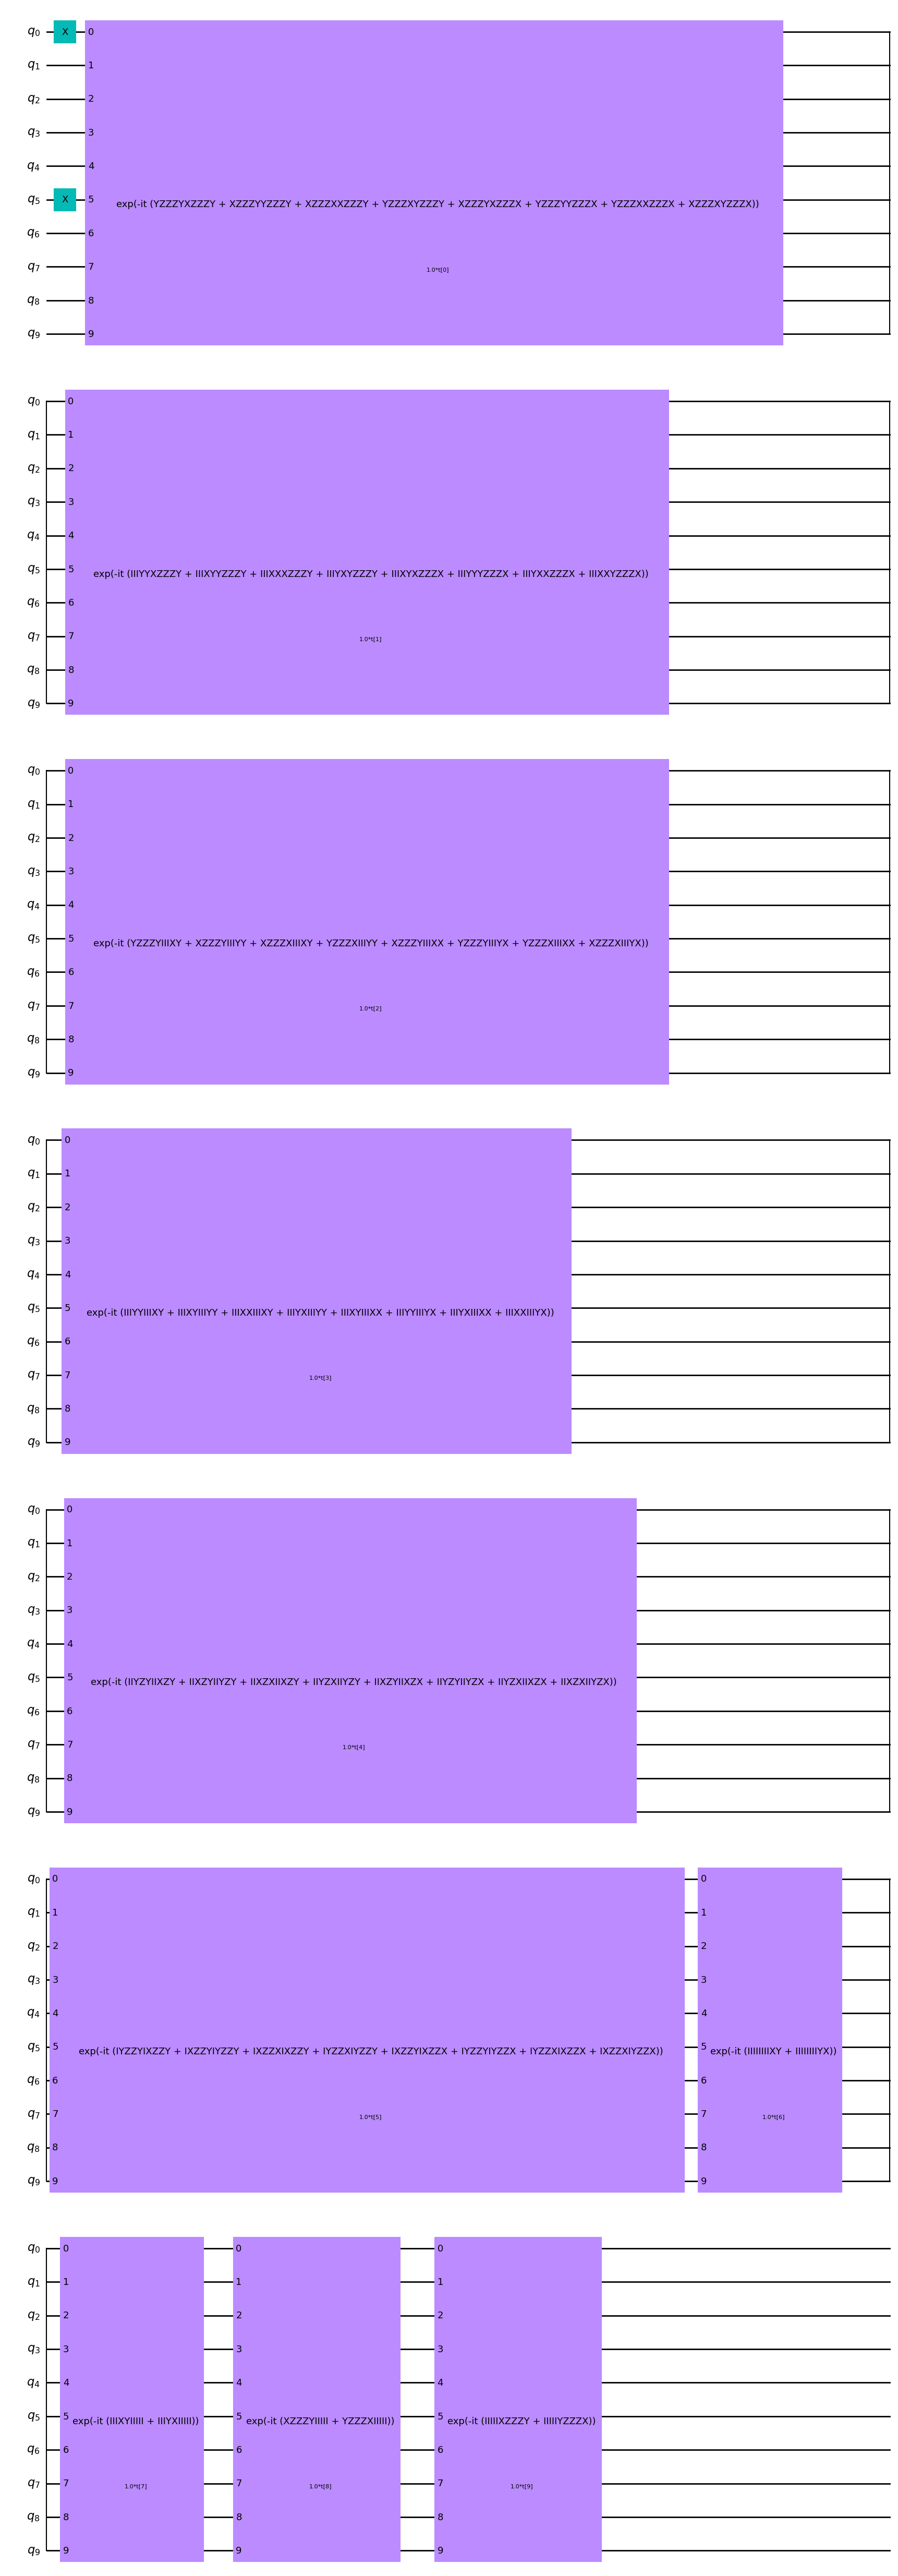

[PauliSumOp(SparsePauliOp(['IIIIIIIIXY', 'IIIIIIIIYX', 'IIIIIIIIXX', 'IIIIIIIIYY', 'IIIIIIIIZI', 'IIIIIIIIIZ', 'IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIYZZYI', 'IIIIIYZZXZ', 'IIIIIXZZYZ', 'IIIIIXZZXI', 'IIIIIIIIYY', 'IIIIIIIIXX', 'IIIIIYZZZY', 'IIIIIYZZIX', 'IIIIIXZZIY', 'IIIIIXZZZX', 'IIIIIIIZXY', 'IIIIIIIZYX', 'IIIIIIZIXY', 'IIIIIIZIYX', 'IIIIIZIIXY', 'IIIIIZIIYX', 'IIIIZIIIXY', 'IIIIZIIIYX', 'IIIYYIIIXY', 'IIIYYIIIYX', 'IIIXXIIIXY', 'IIIXXIIIYX', 'YZZZYIIIXY', 'YZZZYIIIYX', 'XZZZXIIIXY', 'XZZZXIIIYX', 'IIIZIIIIXY', 'IIIZIIIIYX', 'YZZYIIIIXY', 'YZZYIIIIYX', 'XZZXIIIIXY', 'XZZXIIIIYX', 'IIZIIIIIXY', 'IIZIIIIIYX', 'IZIIIIIIXY', 'IZIIIIIIYX', 'ZIIIIIIIXY', 'ZIIIIIIIYX', 'IIIIIIIIYX', 'IIIIIIIIXY', 'IIIIIYZZZX', 'IIIIIYZZIY', 'IIIIIXZZIX', 'IIIIIXZZZY', 'IIIIIIIZXX', 'IIIIIIIZYY', 'IIIIIIZIXX', 'IIIIIIZIYY', 'IIIIIZIIXX', 'IIIIIZIIYY', 'IIIIIYZZXI', 'IIIIIYZZYZ', 'IIIIIXZZXZ', 'IIIIIXZZYI', 'IIIIIIIZZI', 'IIIIIIIZIZ', 'IIIIIIIZIZ', 'IIIIIIIZZI', 'IIIIIIZIZI', 'IIIIIIZIIZ', 'IIIIIIZIIZ', 'IIIIII

In [11]:
display(Adapt_result.raw_result.optimal_circuit.decompose(reps=1).draw('mpl'))
adapt_vqe._excitation_list
adapt_vqe.commutators

In [9]:
adapt_vqe.solver.ansatz.decompose().draw()

┌───┐┌───────────────────────────────────────────────┐»
q_0: ┤ X ├┤0                                              ├»
     └───┘│                                               │»
q_1: ─────┤1                                              ├»
          │                                               │»
q_2: ─────┤2                                              ├»
          │                                               │»
q_3: ─────┤3                                              ├»
          │                                               │»
q_4: ─────┤4                                              ├»
     ┌───┐│  exp(-it (IIIIIIIIXY + IIIIIIIIYX))(1.0*t[0]) │»
q_5: ┤ X ├┤5                                              ├»
     └───┘│                                               │»
q_6: ─────┤6                                              ├»
          │                                               │»
q_7: ─────┤7                                              ├»
          │                                               │»
q_8: ─────┤8                                              ├»
          │                                               │»
q_9: ─────┤9                                              ├»
          └───────────────────────────────────────────────┘»
«     ┌───────────────────────────────────────────────┐»
«q_0: ┤0                                              ├»
«     │                                               │»
«q_1: ┤1                                              ├»
«     │                                               │»
«q_2: ┤2                                              ├»
«     │                                               │»
«q_3: ┤3                                              ├»
«     │                                               │»
«q_4: ┤4                                              ├»
«     │  exp(-it (IIIIIIIXZY + IIIIIIIYZX))(1.0*t[1]) │»
«q_5: ┤5                                              ├»
«     │                                               │»
«q_6: ┤6                                              ├»
«     │                                               │»
«q_7: ┤7                                              ├»
«     │                                               │»
«q_8: ┤8                                              ├»
«     │                                               │»
«q_9: ┤9                                              ├»
«     └───────────────────────────────────────────────┘»
«     ┌───────────────────────────────────────────────┐»
«q_0: ┤0                                              ├»
«     │                                               │»
«q_1: ┤1                                              ├»
«     │                                               │»
«q_2: ┤2                                              ├»
«     │                                               │»
«q_3: ┤3                                              ├»
«     │                                               │»
«q_4: ┤4                                              ├»
«     │  exp(-it (IIIIIIXZZY + IIIIIIYZZX))(1.0*t[2]) │»
«q_5: ┤5                                              ├»
«     │                                               │»
«q_6: ┤6                                              ├»
«     │                                               │»
«q_7: ┤7                                              ├»
«     │                                               │»
«q_8: ┤8                                              ├»
«     │                                               │»
«q_9: ┤9                                              ├»
«     └───────────────────────────────────────────────┘»
«     ┌───────────────────────────────────────────────┐»
«q_0: ┤0                                              ├»
«     │                                               │»
«q_1: ┤1                                              ├»
«     │                                               │»
«q_2: ┤2                                     